### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit
from scipy.io import arff

import sys
sys.path.insert(1, '../')

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
data = arff.loadarff('../data/messidor_features.arff')
retinopathy_df = pd.DataFrame(data[0])

X_retinopathy=retinopathy_df.drop(columns='Class')
y_retinopathy=(retinopathy_df['Class'] == b'1').astype(int)

prep_ret = Preprocessor()

In [4]:
X_ret_train, X_ret_test, y_ret_train, y_ret_test = prep_ret.train_test_split(X_retinopathy, y_retinopathy)

In the task requierements we're asked to remove collinear variables, so we're left with only first 4 options. The GD and SGD results for these 4 are very similar (close to 63%). Thats why I would suggest taking the one where the remaining 2 achieve the best results (which in this case is no scaling and no target balancing). The remaining tests will be perfomed in this particular situation.

In [5]:
remove_coll,balance_classes,scaling=True,True,True
X_train=X_ret_train.copy()
X_test=X_ret_test.copy()
y_train=y_ret_train.copy()
y_test=y_ret_test.copy()
if remove_coll:
    X_train = prep_ret.remove_multicollinearity_fit_transform(X_train)
    X_test = prep_ret.remove_multicollinearity_transform(X_test)
if balance_classes:
    X_train,y_train=prep_ret.class_balancing(X_train,y_train)
if scaling:
    s = StandardScaler()
    X_train = s.fit_transform(X_train)
    X_test = s.transform(X_test)  
#One Hot Encoding- niepotrzebne tutaj
#X_train = prep_ret.one_hot_encoding_fit_transform(X_train)
#X_test = prep_ret.one_hot_encoding_transform(X_test)

#W przypadku gdy jest scaling to X_train i X_test i tak już są numpy_array
#X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
#X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

8 numerical features left in dataset  0  categorical
Training dataset has now  863 obervations. 53.070683661645425  percent is in positive group.


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [6]:
lr=0.01
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=0.1),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

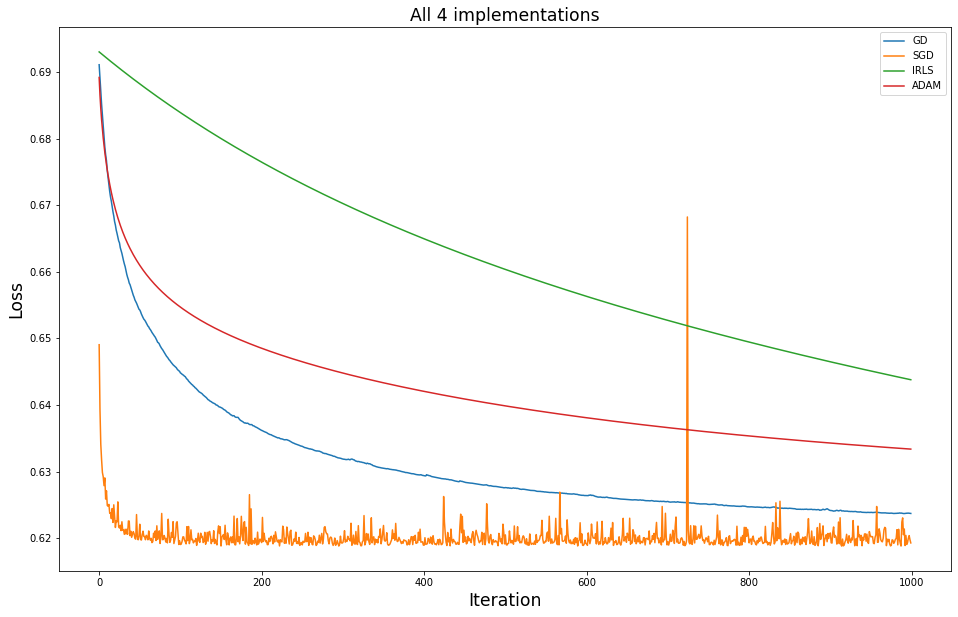

In [7]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.show()

#### 2. Check how the value of learning rate and other parameters affect the results.

In [8]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=11)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}

res_test_learning_rates=experiments.test_learning_rates(X_train=X_train,
                                                        y_train=y_train,
                                                        X_test=X_test,
                                                        y_test=y_test,
                                                        l_rates=tested_l_rates,
                                                        algorithms=tested_algorithms,batch_size=0.1)
#print(res_test_learning_rates['accuracy'].mean())
res_test_learning_rates.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False)

,learning_rate,method,accuracy,recall,precision,F_measure
13,0.120004,SGD,0.670,0.627,0.716,0.669
10,0.140003,SGD,0.663,0.621,0.709,0.662
22,0.060007,SGD,0.660,0.647,0.692,0.669
7,0.160002,SGD,0.660,0.627,0.701,0.662
28,0.020009,SGD,0.656,0.641,0.690,0.664
0,0.200000,GD,0.649,0.699,0.660,0.679
2,0.200000,ADAM,0.649,0.647,0.678,0.662
5,0.180001,ADAM,0.649,0.647,0.678,0.662
8,0.160002,ADAM,0.649,0.647,0.678,0.662
11,0.140003,ADAM,0.649,0.647,0.678,0.662


From the informations above (tested for n_epochs=100,175 and 250) we conclude that the best learning rates are:
- 0.06 or 0.12 for ADAM (its lr decreases a little with each epoch)
- 0.08 or 0.12 for SGD
- 0.12 or 0.18 for GD (batch size=0.1*size(dataset))

In [9]:
tested_betas_1=np.linspace(start=0.75,stop=.97,num=12)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)

res_test_betas=experiments.test_betas(X_train=X_train, 
                                      y_train=y_train,
                                      X_test=X_test,
                                      y_test=y_test,
                                      tested_betas1=tested_betas_1,
                                      tested_betas2=tested_betas_2,lr=0.12,n_epochs=40)

res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

,beta1,beta2,accuracy,recall,precision,F_measure
62,0.87,0.92,0.652778,0.686275,0.668790,0.677419
63,0.87,0.93,0.652778,0.686275,0.668790,0.677419
70,0.89,0.90,0.652778,0.686275,0.668790,0.677419
71,0.89,0.91,0.652778,0.686275,0.668790,0.677419
72,0.89,0.92,0.652778,0.686275,0.668790,0.677419
82,0.91,0.92,0.652778,0.686275,0.668790,0.677419
58,0.85,0.98,0.649306,0.699346,0.660494,0.679365
59,0.85,0.99,0.649306,0.699346,0.660494,0.679365
68,0.87,0.98,0.649306,0.699346,0.660494,0.679365
69,0.87,0.99,0.649306,0.699346,0.660494,0.679365


The experiments (tested n_epochs=30, 40, 50, 75 ,100) above have shown that beta1=0.97 performs definetelly the best, values of beta2 paramenter doesn't have a big incluence on the models performanc however always beta_2=0.94 was often mong the best ones

#### 3. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

In [10]:
n_epochs=1000

batch_size_gd=0.1
lr_gd=0.12

lr_sgd=0.12

lr_adam=0.12
beta1_adam=0.97
beta2_adam=0.94

models = {
    'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}

In [11]:
res_final=experiments.final_comparisson(X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test,
                                        models=models)

res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)

,model,accuracy,recall,precision,f_measure
3,ADAM,0.659722,0.653595,0.689655,0.671141
2,IRLS,0.645833,0.699346,0.656442,0.677215
0,GD,0.645833,0.640523,0.675862,0.657718
1,SGD,0.645833,0.640523,0.675862,0.657718
4,LDA,0.635417,0.718954,0.639535,0.676923
6,LR,0.631944,0.640523,0.657718,0.649007
7,kNN,0.625000,0.620915,0.655172,0.637584
5,QDA,0.534722,0.196078,0.731707,0.309278


What one can find surprising is that the simpler alorithms like GD and SGD when using the best performing parameters
have outperformed (slightly) the IRLS algoritm. 5 best performing classifiers have achieved quite similar results. On the other hand 4 out of 5 worst performing classifiers are "out of the box" showing how much parameter
tuning imacts the results. Especially kNN and QDA have performed very poorly

#### 5. Comparing convergence analysis for the "best" parameters.

In [12]:
n_epochs=1000

batch_size_gd=0.1
lr_gd=0.12

lr_sgd=0.12

lr_adam=0.12
beta1_adam=0.97
beta2_adam=0.94

lr_models = {
     'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8)
 }

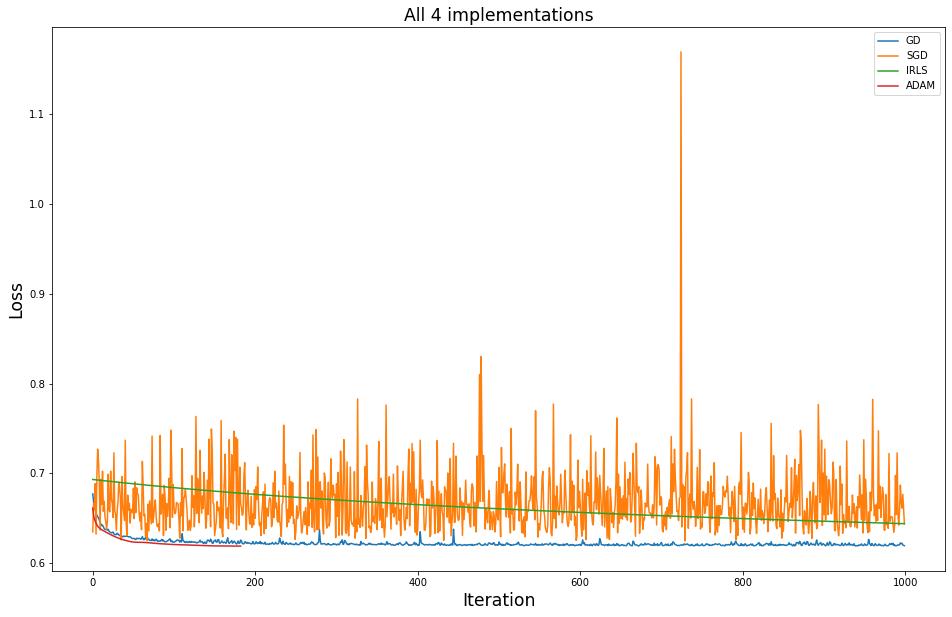

In [13]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.show()